## Notebook 2 — Modeling (Load Splits + Random Forest)

In Notebook 1, we already:
1) built `X_final` (structured + embeddings)
2) created the target `y` (revenue_log)
3) split into train/validation/test
4) saved all splits to disk as `.parquet`

So here, we will **load** those saved splits and start modeling.


In [8]:
#roy
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [9]:
# roy
# Helping using the evaluation metrics 

def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {label} ---")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R²  :", r2)
    print()

    return {"label": label, "mae": mae, "rmse": rmse, "r2": r2}


In [10]:
#roy
#  Loading the saved splits from Notebook 1
# These files were created at the end of the first notebook:
# X_train.parquet, X_val.parquet, X_test.parquet
# y_train.parquet, y_val.parquet, y_test.parquet

X_train = pd.read_parquet("X_train.parquet")
X_val   = pd.read_parquet("X_val.parquet")
X_test  = pd.read_parquet("X_test.parquet")

# y files were saved as 1-column DataFrames 
# convert to Series with .squeeze()
y_train = pd.read_parquet("y_train.parquet").squeeze()
y_val   = pd.read_parquet("y_val.parquet").squeeze()
y_test  = pd.read_parquet("y_test.parquet").squeeze()

print("Loaded shapes:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("X_test :", X_test.shape,  " y_test :", y_test.shape)


Loaded shapes:
X_train: (4353, 1746)  y_train: (4353,)
X_val  : (933, 1746)  y_val  : (933,)
X_test : (933, 1746)  y_test : (933,)


## Random Forest model (Revenue prediction)

In this section, we train a Random Forest model to predict expected box-office revenue (log scale) using:
- film attributes (budget, genre, timing, scores)
- pre-release expert review signals (text embeddings)

We split the data into train / validation / test to avoid “peeking” at the test set.
We tune the model settings using validation, and evaluate once on the test set.


In [ ]:
#roy
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Dataset split reuse

The train, validation, and test splits used in this notebook were created in the first notebook and reused here to ensure consistency across all models.  
This avoids re-splitting the data and ensures that model performance comparisons are fair and not affected by different data partitions.


In [ ]:
#roy
rf_baseline.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

## Baseline Random Forest — Validation Performance

Now that the baseline Random Forest is trained on the **training set**, we evaluate it on the **validation set**.


- The **validation set** is used to compare models and decide improvements (like tuning).
- The **test set** is kept untouched until the end, so it gives an unbiased “final score”.


In [15]:
#roy
# Making predictions on the validation set.



y_val_pred_base = rf_baseline.predict(X_val)

# Evaluating on how well the baseline Random Forest performs on the validation data.
# This gives us a reference point before doing any hyperparameter tuning.
# The metrics show how large the prediction errors are on average as well as how well the model explains revenue differences across films

baseline_scores = evaluate_regression(
    y_true=y_val,
    y_pred=y_val_pred_base,
    label="Random Forest (Baseline) - Validation"
)

# Storing the baseline results so we can compare them later with the tuned model
baseline_scores


--- Random Forest (Baseline) - Validation ---
MAE : 1.3536899082089078
RMSE: 1.880319229670989
R²  : 0.6301640747991833



{'label': 'Random Forest (Baseline) - Validation',
 'mae': 1.3536899082089078,
 'rmse': np.float64(1.880319229670989),
 'r2': 0.6301640747991833}

## Hyperparameter Tuning 

The baseline model is a good starting point, however a  Random Forest model will perform better as it often improves by tuning key settings such as:
- number of trees
- tree depth
- minimum samples per split/leaf

We use **RandomizedSearchCV** because it is efficient:  
it tries several good parameter combinations without testing every possible option.

Tuning is done using **cross-validation on the training set** only (no test/date leakage).


In [16]:
#roy
from sklearn.model_selection import RandomizedSearchCV

In [17]:
#roy
# Defining the range of Random Forest settings we want to test.
# The goal here is to improve model performance without making the search too complex or slow.

# We focus on the most important parameters:
#  n_estimators: number of trees in the forest (more trees means more stable, but slower)
#  max_depth which means how deep each tree is allowed to grow (controls overfitting)
# min_samples_split / min_samples_leaf: prevent the trees from becoming too specific
#  max_features which means how many features are considered at each split

# This search space is intentionally limited as it is large enough to find a good model.

param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}



In [18]:
#roy
# Creating a Random Forest model that will be used specifically for hyperparameter tuning.
# At this stage, it should be only set the basic options which are
# 1. random_state for reproducibility  and,
# 2. n_jobs = -1 to use all available CPU cores and speed up training
#
# The remaining model settings (such as tree depth and number of trees) will be tested and selected automatically in the next step.

rf_for_search = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)


In [19]:
#roy
# Setting up a randomized hyperparameter search for the Random Forest model.
# Instead of testing every possible combination, this approach tries a limited number of randomly selected configurations, which is more efficient.

random_search = RandomizedSearchCV(
    estimator=rf_for_search,
    param_distributions=param_dist,
    n_iter=20,                 # trying 20 different parameter combinations
    scoring="neg_root_mean_squared_error",
    cv=3,                      # cross-validation within the training set
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Important points to note: 
#  The search is performed only on the training data.
# 3-fold cross-validation is used to get more reliable performance estimates.
#  RMSE is used as the evaluation metric, as it reflects prediction error size.
# and the validation and test sets remain untouched at this stage.


In [20]:
#roy
# Running the hyperparameter search using the training data only.
# This finds the Random Forest settings that perform best during cross-validation.

random_search.fit(X_train, y_train)

# Displaying the best-performing parameter combination and its validation score
print("Best parameters found:", random_search.best_params_)
print("Best CV score (negative RMSE):", random_search.best_score_)   #content check


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10}
Best CV score (negative RMSE): -1.7911651464896317


##  Tuned Random Forest for Validation Performance

Next step is to take the best tuned model and evaluate it on the validation set.
This tells whether the tuning improved performance compared to the baseline.


In [21]:
#roy
# Selecting the best Random Forest model found during hyperparameter tuning
rf_tuned = random_search.best_estimator_


In [22]:
#roy

# Making predictions on the validation set using the tuned model
y_val_pred_tuned = rf_tuned.predict(X_val)

In [23]:
#roy
# Evaluating whether the tuning improved performance compared to the baseline model
tuned_scores = evaluate_regression(
    y_true=y_val,
    y_pred=y_val_pred_tuned,
    label="Random Forest (Tuned) - Validation"
)

--- Random Forest (Tuned) - Validation ---
MAE : 1.3322383681287129
RMSE: 1.8495383825156717
R²  : 0.6421734037726377



In [24]:
#roy

tuned_scores # Storing the tuned validation results for later comparison

{'label': 'Random Forest (Tuned) - Validation',
 'mae': 1.3322383681287129,
 'rmse': np.float64(1.8495383825156717),
 'r2': 0.6421734037726377}

## Baseline vs Tuned (A Comparison)

This small table makes it easy to compare the improvements.



In [25]:
#roy
# Comparing the baseline and tuned Random Forest results side by side.
# This makes it easier to see whether hyperparameter tuning actually improved the model’s performance on the validation data.

comparison_df = pd.DataFrame([
    baseline_scores,
    tuned_scores
])

comparison_df

,label,mae,rmse,r2
0,Random Forest (Baseline) - Validation,1.353690,1.880319,0.630164
1,Random Forest (Tuned) - Validation,1.332238,1.849538,0.642173


## Final Evaluation on the Test Set 

Now that the best model is selected using the validation set, we evaluate it once on the **test set**.

 This is the most realistic estimate of how well the model would perform on new, unseen movies.



In [26]:
#roy
# Making predictions on the test set.
# This is the final evaluation step that is done only once,after the model has been fully tuned using training and validation data.

y_test_pred = rf_tuned.predict(X_test)

In [27]:
#roy
# Evaluating how well the tuned model performs on completely unseen films.
# These results give the most realistic estimate of real-world performance.

test_scores = evaluate_regression(
    y_true=y_test,
    y_pred=y_test_pred,
    label="Random Forest (Tuned) - Test (Final)"
)


--- Random Forest (Tuned) - Test (Final) ---
MAE : 1.4537737266887985
RMSE: 1.9867347632306145
R²  : 0.6091714395082652



In [28]:
#roy
# Storing the final test results for reporting
test_scores

{'label': 'Random Forest (Tuned) - Test (Final)',
 'mae': 1.4537737266887985,
 'rmse': np.float64(1.9867347632306145),
 'r2': 0.6091714395082652}

##  Feature Importance (What Drives Revenue Predictions?)

Random Forest can estimate which features were most important for making predictions.
This is useful because it highlights what factors influence predicted revenue most.


- With embeddings, some feature names may look like `emb_0`, `emb_1`, etc.
- Structured features (budget, genre encodings, etc.) should still appear and can be interpreted directly.


In [29]:
#roy
# Extracting feature importance scores from the tuned Random Forest model.
# This helps understand which inputs had the strongest influence on the revenue predictions.

importances = rf_tuned.feature_importances_

In [30]:
#roy
#Combining feature names with their importance scores into a table
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

In [31]:
#roy
# Displaying the top 20 most influential features
feature_importance_df.head(20)

,feature,importance
0,budget_log,0.716151
2,userscore,0.033842
980,emb_2,0.008755
1543,emb_565,0.008312
1,metascore,0.007776
1317,emb_339,0.003571
1006,emb_28,0.001792
1547,emb_569,0.001772
1654,emb_676,0.001691
1388,emb_410,0.001446


## Plotting Top 15 Feature Importances

This plot visualises the strongest drivers of the model.



In [ ]:
#roy
import matplotlib.pyplot as plt

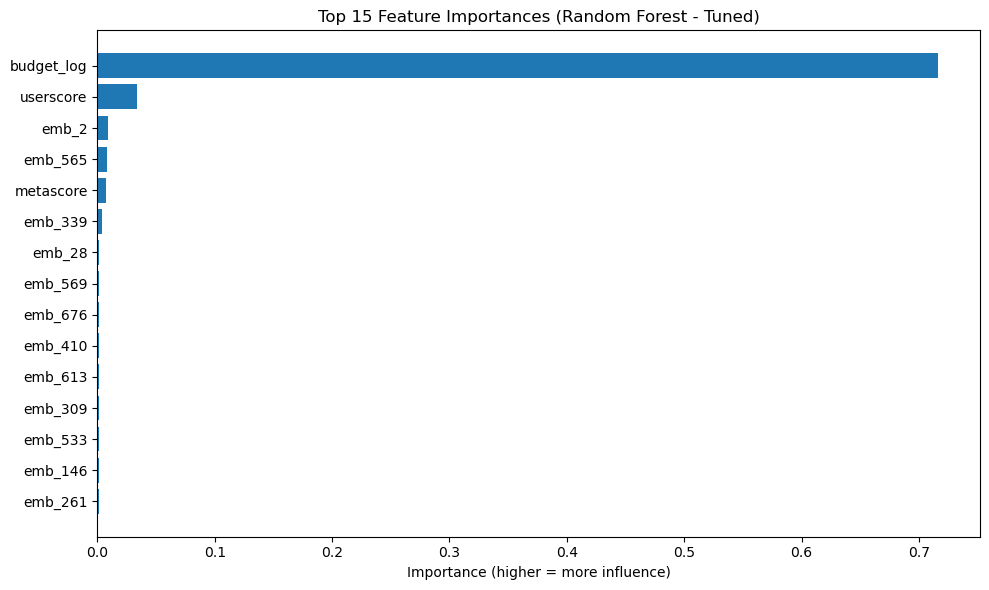

In [33]:
#roy
# Visualising the most important features from the tuned Random Forest model.
# This makes it easier to see which factors had the biggest influence on the revenue predictions, compared to reading a long table.

top_n = 15
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
plt.xlabel("Importance (higher = more influence)")
plt.title(f"Top {top_n} Feature Importances (Random Forest - Tuned)")
plt.tight_layout()
plt.show()

Figure # Key Drivers of Box-Office Revenue (Random Forest – Tuned Model)

The plot shows the most influential factors used by the tuned Random Forest model when predicting box-office revenue. Production budget (log-transformed) is by far the strongest driver, highlighting its central role in commercial performance. Critic and user scores, along with selected expert-review signals, also contribute to the prediction, indicating that early market sentiment adds value beyond budget alone.


## Conclusion

This section applied a Random Forest regression model to predict **log-transformed box office revenue (`revenue_log`)** using a combination of structured movie attributes and high-dimensional transformer-based text embeddings from pre-release expert reviews.

The baseline Random Forest achieved an **R² of 0.63 on the validation set**, indicating that the model explains a substantial proportion of the variance in movie revenue. After applying hyperparameter tuning with RandomizedSearchCV, validation performance improved to an **R² of 0.64**, alongside modest reductions in MAE and RMSE. This confirms that tuning contributed to more stable and accurate predictions without overfitting.

When evaluated once on the untouched test set, the tuned model achieved an **R² of 0.61**. The limited drop in performance compared to validation suggests that the model generalises reasonably well to unseen data, despite the high dimensionality of the feature space (1,746 features). This supports the robustness of the modelling approach.

Feature importance analysis shows that **production budget (log-transformed)** is by far the dominant predictor of revenue, accounting for approximately **72% of total importance**. This aligns strongly with industry expectations and confirms the economic validity of the model. In addition, **user score and critic metascore** emerge as meaningful secondary drivers, reflecting the role of audience and expert reception.

Several transformer embedding dimensions also appear among the top features. While these individual embedding features are not directly interpretable, their presence indicates that **latent patterns in pre-release expert reviews provide additional predictive signal** beyond traditional structured variables.

Overall, the results demonstrate that combining structured movie data with textual embeddings yields a model that is both **predictively effective and business-relevant**, while maintaining clear separation between training, validation, and test phases to avoid data leakage.


### Interpretation of Feature Importances

The feature importance results indicate that **budget_log** is the primary driver of predicted box office revenue, far outweighing all other variables. This reflects the strong relationship between production investment, marketing reach, and commercial performance.

Review-based variables such as **userscore** and **metascore** also contribute meaningfully, suggesting that both audience perception and critical reception influence revenue outcomes.

Several transformer embedding features appear among the top predictors. Although these dimensions are not directly interpretable, they capture nuanced semantic patterns in expert reviews, indicating that early narrative tone and sentiment provide incremental predictive value beyond structured inputs.
